In [1]:
import os
parent_dir = os.path.split(os.getcwd())[0]
%cd {parent_dir}

/home/chickencurry/diffusion-vi-neural-processes/neural-process/code


In [2]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision

from np import NeuralProcess
from train import train_2d
from utils import split_context_target
from visualize import (sample_latent_space, visualize_batch_2d,
                       visualize_latent_space, visualize_losses)

In [3]:
device = None

try:
    import torch_directml
    device = torch_directml.device()
except ModuleNotFoundError:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
print(device)

privateuseone:0


In [4]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

dataset = torchvision.datasets.MNIST(root='/home/chickencurry/diffusion-vi-neural-processes/data', train=True, transform=transform, download=True)
dataloader = DataLoader(dataset=dataset, batch_size=512, shuffle=True, num_workers=10)
gen_dataloader = DataLoader(dataset=dataset, batch_size=1, shuffle=True, num_workers=10)

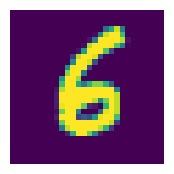

torch.Size([512, 1, 28, 28])


In [5]:
visualize_batch_2d(batch=next(iter(dataloader)))
print(next(iter(dataloader))[0].shape)

In [6]:
model = NeuralProcess(x_dim=1, y_dim=1, r_dim=16, z_dim=16, h_dim=256).to(device)
# model.load_state_dict(torch.load('../models/np-mnist.pth'))

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
recon_criterion = nn.BCEWithLogitsLoss(reduction='mean')

In [7]:
total_recon_losses = []
total_kl_divs = []

In [8]:
recon_losses, kl_divs = train_2d(
    model=model, 
    device=device, 
    dataloader=dataloader, 
    optimizer=optimizer, 
    recon_criterion=recon_criterion, 
    num_epochs=30
)

total_recon_losses.extend(recon_losses)
total_kl_divs.extend(kl_divs)

  0%|          | 0/118 [00:00<?, ?it/s]

/home/chickencurry/miniconda3/envs/directml/lib/python3.11/site-packages/torch/nn/functional.py:3226: UserWarning: The operator 'aten::log_sigmoid_forward' is not currently supported on the DML backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /__w/1/s/pytorch-directml-plugin/torch_directml/csrc/dml/dml_cpu_fallback.cpp:15.)
  return torch.binary_cross_entropy_with_logits(input, target, weight, pos_weight, reduction_enum)
100%|██████████| 118/118 [00:39<00:00,  2.99it/s, epoch=29, factor=0.621, kl_div=0.561, loss=0.967, recon_loss=0.406]  


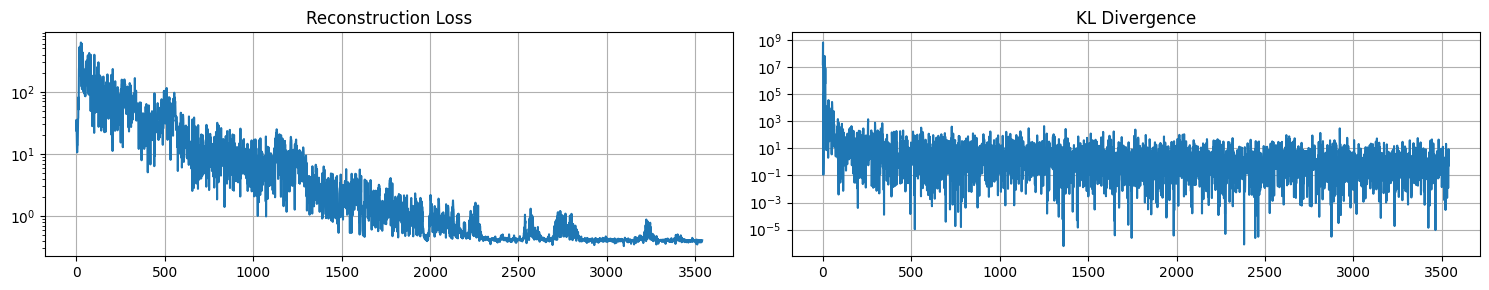

In [18]:
import matplotlib.pyplot as plt

_, ax = plt.subplots(1, 2, figsize=(15, 3))

ax[0].plot(total_recon_losses)
ax[0].set_title("Reconstruction Loss")
ax[0].grid()
ax[0].set_yscale("log")
# ax[0].set_ylim(0, 10)

ax[1].plot(total_kl_divs)
ax[1].set_title("KL Divergence")
ax[1].grid()
ax[1].set_yscale("log")
# ax[1].set_ylim(0, 100)

plt.tight_layout()
plt.show()

In [16]:
from tqdm import tqdm
from utils import img_batch_to_sequence

num_samples = 10000

mus = []
logvars = []

for i, (batch) in tqdm(enumerate(gen_dataloader), total=num_samples):
    sequence = img_batch_to_sequence(batch[0]).to(device)

    model.eval()
    _, mu, logvar = model.encode(sequence)

    mus.append(mu.cpu().detach().numpy())
    logvars.append(logvar.cpu().detach().numpy())

    if i > num_samples:
        break

10001it [00:28, 348.38it/s]                          


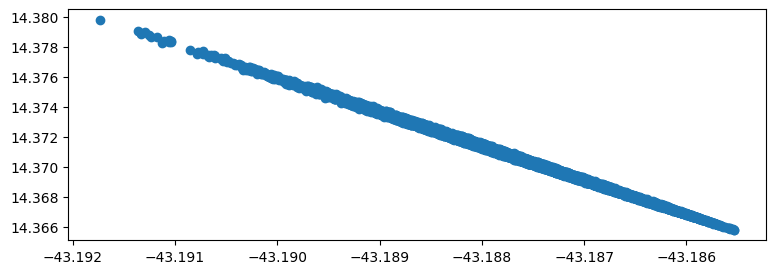

In [29]:
visualize_latent_space(
    mus=mus, 
    logvars=logvars, 
    dim_1=0, 
    dim_2=15
)

In [30]:
def sequence_to_img_batch(sequence: torch.Tensor, batch_size: int, channels: int, height: int, width: int) -> torch.Tensor:
    # The input sequence has shape (batch_size, seq_length, 2)
    
    # Extract indices and values from the sequence
    indices = sequence[..., 0].long()  # Shape: (batch_size, seq_length)
    values = sequence[..., 1]          # Shape: (batch_size, seq_length)

    # Prepare a tensor to hold the restored image (batch_size, channels, height, width)
    img_batch = torch.zeros(batch_size, channels * height * width, device=sequence.device)

    # Use scatter to place the values in the correct positions based on indices
    img_batch.scatter_(1, indices, values)

    # Reshape the flat image tensor back to (batch_size, channels, height, width)
    img_batch = img_batch.view(batch_size, channels, height, width)

    return img_batch

In [44]:
sample = next(iter(gen_dataloader))

factor = 0.1 # max(min(0.9, np.random.random()), 0.1)
sequence = img_batch_to_sequence(sample[0]).to(device)
context, target = split_context_target(sequence, factor)

torch.Size([1, 706, 1])
torch.Size([1, 706, 1])
torch.Size([1, 1, 28, 28])


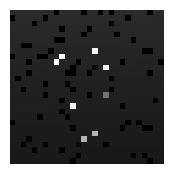

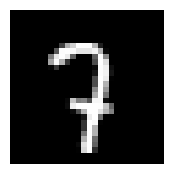

In [59]:
n_samples = 1

mus, logvars, _, _ = model.sample(context, target[:, :, 0:1], n_samples)
mus = torch.cat(mus, dim=0)
mus = torch.sigmoid(mus)
print(mus.shape)
print(target[:, :, 0:1].shape)

combined = torch.cat([target[:, :, 0:1].repeat(n_samples, 1, 1), mus], dim=2) # target[:, :, 1:2].repeat(n_samples, 1, 1)]
with_context = torch.cat([context, combined], dim=1)

img_batch = sequence_to_img_batch(with_context, batch_size=n_samples, channels=1, height=28, width=28)
print(img_batch.shape)

plt.figure(figsize=(2, 2))
plt.imshow(img_batch[0].detach().cpu().permute(1, 2, 0), cmap="gray")
plt.axis("off")
plt.show()

plt.figure(figsize=(2, 2))
plt.imshow(sample[0][0].detach().cpu().permute(1, 2, 0), cmap="gray")
plt.axis("off")
plt.show()

In [28]:
torch.save(model.state_dict(), '../models/np-mnist.pth')